In [1]:
import numpy as np
import torch 

from src.neural_net import *

## Data

In [2]:
bundle = np.load("data/data.npz")


In [3]:

X = bundle["X"]; Y = bundle["Y"]; U = bundle["U"]; Xtraj = bundle["Xtraj"]
OBJ = bundle["OBJ"]; status = bundle["STATUS"]

In [4]:
X

array([[1.04580152, 0.77967432, 2.76353902, ..., 0.        , 0.14414296,
        0.        ],
       [1.65870394, 1.6379871 , 2.75758501, ..., 0.        , 5.21653707,
        0.        ],
       [2.40195387, 2.52297397, 5.77865938, ..., 0.        , 3.53221792,
        0.        ],
       ...,
       [4.40745667, 0.95742816, 0.34984483, ..., 0.        , 0.57524068,
        0.        ],
       [4.15956533, 2.97074408, 1.78139896, ..., 0.        , 1.65672769,
        0.        ],
       [7.57844188, 1.79423069, 0.41093445, ..., 0.        , 0.55295969,
        0.        ]], shape=(100000, 42))

In [5]:
Y

array([[3, 2, 2, ..., 1, 1, 0],
       [2, 2, 3, ..., 1, 0, 0],
       [0, 1, 2, ..., 1, 0, 0],
       ...,
       [3, 3, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0]], shape=(100000, 20))

## Supervised Learning Test

In [6]:
x_data = torch.tensor(X, dtype=torch.float32)
y_data = torch.tensor(Y, dtype=torch.float32)

alldataset = torch.utils.data.TensorDataset(x_data, y_data)
data_loader = torch.utils.data.DataLoader(alldataset, batch_size=64, shuffle=True)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [8]:
# Create train and test datasets
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(Y_train, dtype=torch.float32)
x_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 80000
Test samples: 20000


### Training

In [9]:
nn_model = MLPWithSoftmaxSTE(
    insize=42,
    outsize=20,
    integer_choices=[0, 1, 2, 3],
    hsizes=[128] * 4
)

In [10]:
# Training configuration
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model = nn_model.to(device)

# criterion = nn.MSELoss()
criterion = nn.HuberLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
test_losses = []
test_accuracies = []

In [11]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    nn_model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = nn_model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Evaluation phase
    nn_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs = nn_model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            
            # Calculate accuracy (exact match)
            correct += (outputs == batch_y).all(dim=1).sum().item()
            total += batch_x.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.6f}")
        print(f"  Test Loss: {test_loss:.6f}")
        print(f"  Test Accuracy: {test_accuracy:.2f}%")

Epoch [10/100]
  Train Loss: 0.030339
  Test Loss: 0.029005
  Test Accuracy: 35.24%
Epoch [20/100]
  Train Loss: 0.024461
  Test Loss: 0.024120
  Test Accuracy: 40.45%
Epoch [30/100]
  Train Loss: 0.021425
  Test Loss: 0.021193
  Test Accuracy: 44.62%
Epoch [40/100]
  Train Loss: 0.020120
  Test Loss: 0.020349
  Test Accuracy: 45.37%
Epoch [50/100]
  Train Loss: 0.018868
  Test Loss: 0.019189
  Test Accuracy: 47.17%
Epoch [60/100]
  Train Loss: 0.017903
  Test Loss: 0.018918
  Test Accuracy: 48.25%
Epoch [70/100]
  Train Loss: 0.017384
  Test Loss: 0.018540
  Test Accuracy: 48.73%
Epoch [80/100]
  Train Loss: 0.016790
  Test Loss: 0.018064
  Test Accuracy: 49.73%
Epoch [90/100]
  Train Loss: 0.016183
  Test Loss: 0.017363
  Test Accuracy: 50.74%
Epoch [100/100]
  Train Loss: 0.015696
  Test Loss: 0.016888
  Test Accuracy: 51.55%


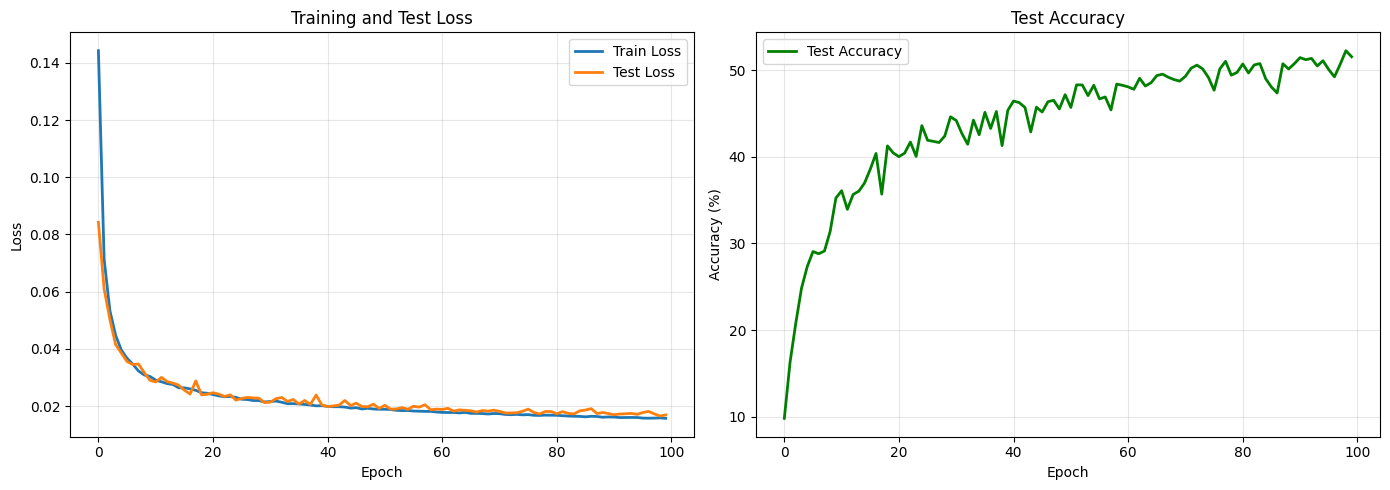

In [12]:
# Plot training curves
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(test_losses, label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(test_accuracies, label='Test Accuracy', color='green', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Test predictions on a few samples
nn_model.eval()
with torch.no_grad():
    sample_x = x_test[:5].to(device)
    sample_y = y_test[:5]
    predictions = nn_model(sample_x).cpu()
    
    print("Sample Predictions vs Ground Truth:")
    print("=" * 60)
    for i in range(5):
        # print(f"Input: {sample_x[i].cpu().numpy()}")
        print(f"Predicted: {predictions[i].numpy()}")
        print(f"Ground Truth: {sample_y[i].numpy()}")
        match_percentage = (predictions[i] == sample_y[i]).float().mean().item() * 100
        print(f"Match Percentage: {match_percentage:.2f}%")
        # print(f"Match: {(predictions[i] == sample_y[i]).item()}")
        print("-" * 60)

Sample Predictions vs Ground Truth:
Predicted: [1. 1. 1. 1. 1. 1. 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 1. 1. 0.]
Ground Truth: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 0.]
Match Percentage: 85.00%
------------------------------------------------------------
Predicted: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 0.]
Ground Truth: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 0.]
Match Percentage: 100.00%
------------------------------------------------------------
Predicted: [3. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Ground Truth: [3. 3. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Match Percentage: 95.00%
------------------------------------------------------------
Predicted: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 1. 1. 1. 1. 0. 0.]
Ground Truth: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 1. 1. 1. 0. 0.]
Match Percentage: 95.00%
------------------------------------------------------------
Predicted: [0. 1. 1. 1.